In [3]:
import os
import glob
import json
import datetime as dt
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

## Load various tables from PostgreSQL database

In [4]:
df_teams = sql.df_from_query("""
    SELECT * from teams
""")
team2color = dict(zip(df_teams.team_id, df_teams.color))
flair2team = dict(zip(df_teams.flair_name, df_teams.team_id))
df_teams.head()

,team_id,display_name,flair_name,conference,location,year_start,year_end,color
0,abilene-christian,Abilene Christian,Abilene Christian Wildcats,Southland,"Abilene, Texas",1971,2020,#4e2583
1,air-force,Air Force,Air Force Falcons,MWC,"USAF Academy, Colorado",1958,2020,#0061aa
2,akron,Akron,Akron Zips,MAC,"Akron, Ohio",1902,2020,#a89968
3,alabama-am,Alabama A&M,None,SWAC,"Normal, Alabama",2000,2020,#661012
4,alabama,Alabama,Alabama Crimson Tide,SEC,"Tuscaloosa, Alabama",1913,2020,#aa1c37


In [5]:
df_games = sql.df_from_query("""
    SELECT * FROM game_data WHERE "Season">=2018 ORDER BY "Date"
    """
)
print(df_games.shape)
df_games.head()

(16470, 39)


,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2018,2017-11-10,2017-11-10_maryland_stony-brook,RG,maryland,76,stony-brook,61,-1,-1,...,6,9,5,19,15,13,7,2,19,74.20
1,2018,2017-11-10,2017-11-10_massachusetts_massachusetts-lowell,RG,massachusetts,74,massachusetts-lowell,69,-1,-1,...,23,30,5,21,15,13,9,2,21,71.58
2,2018,2017-11-10,2017-11-10_marshall_tennessee-martin,RG,marshall,102,tennessee-martin,91,-1,-1,...,12,15,9,22,16,21,4,0,29,82.28
3,2018,2017-11-10,2017-11-10_hampton_rider,RG,rider,90,hampton,75,-1,-1,...,13,17,10,28,13,16,3,5,28,76.22
4,2018,2017-11-10,2017-11-10_iowa-state_missouri,RG,missouri,74,iowa-state,59,-1,-1,...,5,11,7,14,11,13,7,1,13,69.28


In [6]:
df_reddit = sql.df_from_query("""
    SELECT date,gid,is_postgame,ups,num_comments FROM gamethreads ORDER BY date
    """
)
print(df_reddit.shape)
df_reddit.head()

(14387, 5)


,date,gid,is_postgame,ups,num_comments
0,2017-11-10,2017-11-10_alabama-birmingham_jacksonville,True,9,0
1,2017-11-10,2017-11-10_alabama_memphis,False,6,81
2,2017-11-10,2017-11-10_arizona_northern-arizona,False,13,82
3,2017-11-10,2017-11-10_baylor_central-arkansas,True,26,13
4,2017-11-10,2017-11-10_clemson_western-carolina,True,6,6


In [7]:
df_comments = sql.df_from_query("""
    SELECT gid,is_postgame,author,author_flair from gamethread_comments
""")
# df_comments.author_flair.head(20)
df_comments.author_flair = df_comments.author_flair.apply(lambda x: [x.strip('"') for x in x.strip('{}').split(',')])
print(df_comments.shape)
df_comments.head()

(387257, 4)


,gid,is_postgame,author,author_flair
0,2019-11-06_binghamton_cornell,True,CaffeinationGoat,"[Connecticut Huskies, Binghamton Bearcats]"
1,2019-11-06_binghamton_cornell,True,cheesoidhateself,[Cornell Big Red]
2,2019-11-06_binghamton_cornell,True,PAPA_JOHNS_ZIMBABWE,[NJIT Highlanders]
3,2019-11-06_binghamton_cornell,True,IsYouWitItYaBish,[Wisconsin Badgers]
4,2019-11-06_boston-college_wake-forest,False,mrfixit420,[Wake Forest Demon Deacons]


### Get counts of each flair, and plot the top teams

In [8]:
flairs = pd.Series([x for subl in df_comments.drop_duplicates('author').author_flair.values.tolist() for x in subl])
# flairs = pd.Series([x for subl in df_comments.author_flair.values.tolist() for x in subl])
print(flairs.nunique())
print(df_comments.author.nunique())
flairs.value_counts().head(20)

591
24355


                              5479
Michigan Wolverines            976
Michigan State Spartans        860
North Carolina Tar Heels       711
Kentucky Wildcats              685
Kansas Jayhawks                659
Purdue Boilermakers            561
Virginia Cavaliers             530
Duke Blue Devils               510
Indiana Hoosiers               449
Wisconsin Badgers              445
Maryland Terrapins             413
Illinois Fighting Illini       400
Tennessee Volunteers           389
NC State Wolfpack              379
Ohio State Buckeyes            373
Auburn Tigers                  348
Virginia Tech Hokies           346
Syracuse Orange                343
West Virginia Mountaineers     333
dtype: int64

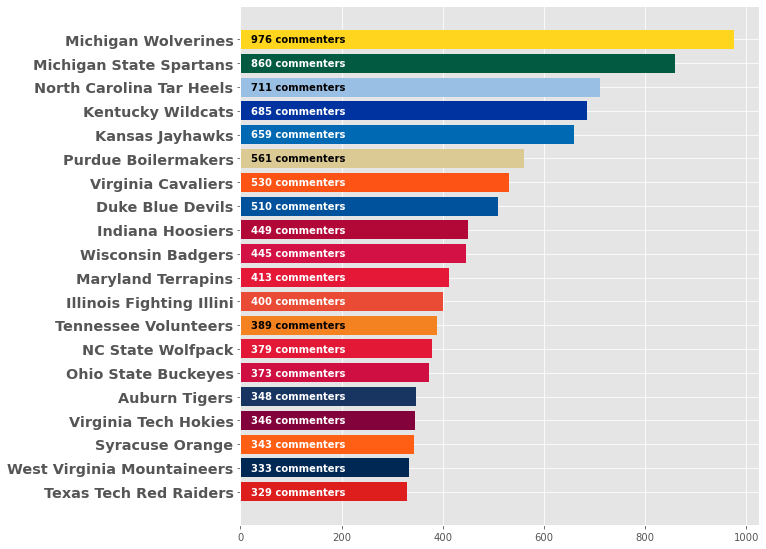

In [9]:
topteams = flairs.value_counts().head(21)
fs = topteams.index.values[1:]
counts = topteams.values[1:]

xpos = list(reversed([i for i in range(len(fs))]))

plt.figure(figsize=(9,9))
for i in range(len(fs)):
    plt.barh([xpos[i]], [counts[i]], color=team2color[flair2team[fs[i]]])
for i in range(len(fs)):
    c = team2color[flair2team[fs[i]]]
    intensity = np.mean([int(x,16) for x in [c[1:3], c[3:5], c[5:7]]])
    tc = 'w' if intensity < 127 else 'k'
    text = "{0:d} commenters".format(counts[i])
    size = 'medium'
    plt.text(20, xpos[i], text, color=tc, fontsize=size, fontweight='bold', va='center')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.yticks(xpos, fs, fontsize='x-large', fontweight='bold');
# plt.gca().set_xlim(0,0.08)

### Create mapping from team_id to flair
Get most of the way there with lower-casing and punctuation replacements. Have to hard-code a few in `flair_substitutions.json`

In [10]:
team_ids = df_teams.team_id.values.tolist()
subs = json.load(open('../data/flair_substitutions.json'))
mapping = {}
for flair in flairs.value_counts().index:
    parts = flair.lower().replace('&','').replace('.','').replace("'",'').strip().split()
    for i in range(len(parts)):
        f = '-'.join(parts[:len(parts)-i])
        if f in team_ids and f not in mapping:
            mapping[f] = flair
            break
        if flair in subs and subs[flair] in team_ids and subs[flair] not in mapping:
            mapping[subs[flair]] = flair
            break
print(len(mapping))
pd.Series(flairs[~flairs.isin(mapping.values())]).value_counts().head(20)
with(open('../scripts/flairs.json', 'w')) as fid:
    json.dump(mapping, fid, ensure_ascii=True, indent=4, sort_keys=True)

295


In [11]:
df_comments.author_flair.head()
flair_counts = {}
authors = df_comments.drop_duplicates('author')[['author','author_flair']]
for tid in mapping:
    flair_counts[tid] = authors.author_flair.apply(lambda x:mapping[tid] in x).sum()
for t,c in sorted(flair_counts.items(), key=lambda x:x[1], reverse=True)[:10]:
    print(f"{c:4d} {t}")

 976 michigan
 860 michigan-state
 711 north-carolina
 685 kentucky
 659 kansas
 561 purdue
 530 virginia
 510 duke
 449 indiana
 445 wisconsin


### Get the sum of #authors associated to each of the two teams for each gamethread

In [41]:
def get_nauthors(row):
    tid1, tid2 = row.gid.split('_')[1:]
    return flair_counts.get(tid1,5) + flair_counts.get(tid2,5)
df_reddit["nauthors"] = df_reddit.apply(get_nauthors, axis=1)
df_reddit["norm_num_comments"] = df_reddit.num_comments / np.log10(df_reddit.nauthors)
df_reddit.query('nauthors>1000 & num_comments<20')

,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments
3690,2018-02-06,2018-02-06_iowa_michigan-state,True,2,7,1176,2.279828
3698,2018-02-06,2018-02-06_michigan_northwestern,True,11,8,1048,2.648690
3929,2018-02-13,2018-02-13_auburn_kentucky,False,1,2,1033,0.663548
4510,2018-03-02,2018-03-02_michigan_nebraska,True,1,3,1163,0.978608
12350,2020-01-09,2020-01-09_north-carolina_north-carolina-state,True,21,10,1090,3.292261


### Scatter plot of nauthors vs num_comments

Text(0, 0.5, 'log10(ncomments)')

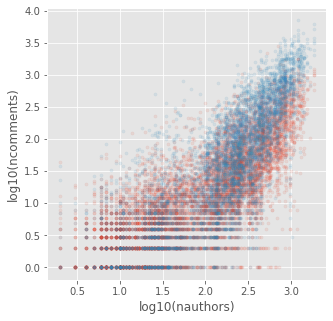

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(df_reddit.nauthors[df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
plt.scatter(np.log10(df_reddit.nauthors[~df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[~df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
plt.xlabel('log10(nauthors)')
plt.ylabel('log10(ncomments)')
# plt.gca().set_ylim(0,2000)

Text(0.5, 0, 'log10((#comments + 1) / sqrt(nauthors))')

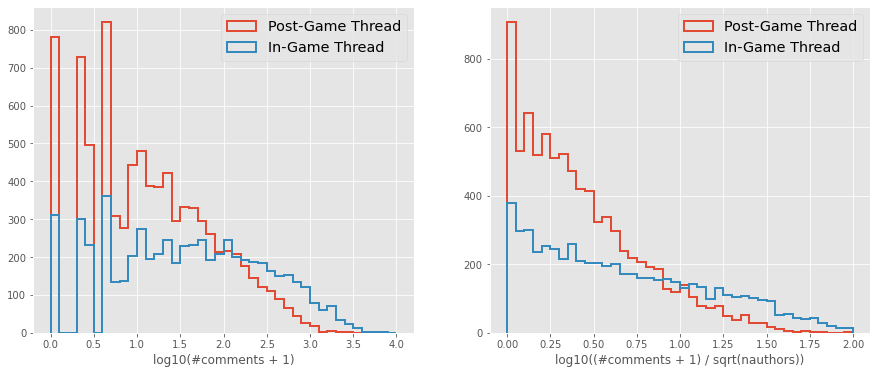

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(np.log10(df_reddit[df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="Post-Game Thread")
axs[0].hist(np.log10(df_reddit[~df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="In-Game Thread")
axs[0].legend(fontsize='x-large')
axs[0].set_xlabel("log10(#comments + 1)", fontsize='large')
axs[1].hist(np.log10(df_reddit[df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="Post-Game Thread")
axs[1].hist(np.log10(df_reddit[~df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="In-Game Thread")
axs[1].legend(fontsize='x-large')
axs[1].set_xlabel("log10((#comments + 1) / sqrt(nauthors))", fontsize='large')

In [71]:
import importlib
importlib.reload(utils)
dates = df_games.Date.unique()
return_cols = [
    'gid','result','HA','rank1','rank2','compratsum','effdiff','preseason_effdiff',
    'blended_prob','prob','preseason_prob',
    'pred_pace_blend',
    'pred_total_blend',
    'pred_margin_blend'
]
df_preds = utils.get_daily_predictions(dates, df_games, model_file='../models/game_regressions.pkl',
                                       pickled_stats_dir='../data/season_stats/{year}',
                                       return_cols=return_cols)
df_preds.head(10)

100%|██████████| 421/421 [00:35<00:00, 12.01it/s]


,gid,result,HA,rank1,rank2,compratsum,effdiff,preseason_effdiff,blended_prob,prob,preseason_prob,pred_pace_blend,pred_total_blend,pred_margin_blend
0,2017-11-11_duke_utah-valley,True,1,1,-1,21.943241,18.891916,23.244,0.940544,0.958614,0.939030,72.503040,149.679055,17.466185
1,2017-11-12_hawaii_north-dakota,True,1,-1,-1,-5.419391,-0.710999,4.688,0.729587,0.753988,0.727304,71.404368,145.607064,5.827073
2,2017-11-12_howard_indiana,False,-1,-1,-1,-1.472926,11.940330,-38.387,0.019999,0.429283,0.014509,69.695001,144.880171,-23.345865
3,2017-11-12_illinois_tennessee-martin,True,1,-1,-1,-0.234373,31.518625,17.899,0.915453,0.983199,0.902858,69.176809,144.805593,14.603981
4,2017-11-12_louisiana-monroe_southern-methodist,False,-1,-1,-1,10.113966,-11.666515,-25.892,0.049120,0.105299,0.045753,65.542970,138.190770,-17.021133
5,2017-11-12_miami-fl_navy,True,1,13,-1,20.957897,18.354036,23.655,0.937190,0.872521,0.941216,65.405648,134.271023,16.194564
6,2017-11-12_monmouth_seton-hall,False,-1,-1,23,22.771610,-13.575260,-18.610,0.086763,0.083081,0.087103,72.069717,147.873670,-14.457348
7,2017-11-12_wisconsin_yale,True,1,-1,-1,26.084565,30.847874,7.612,0.810606,0.974082,0.778561,67.237702,140.400818,8.895082
8,2017-11-12_fairleigh-dickinson_penn-state,False,-1,-1,-1,3.001761,-13.860537,-18.479,0.086451,0.070079,0.088093,72.582575,149.010862,-14.465851
9,2017-11-12_alcorn-state_creighton,False,-1,-1,-1,4.328909,-34.245844,-30.533,0.028563,0.016561,0.029997,71.748981,147.298527,-22.176727


In [72]:
merged = df_reddit.merge(df_preds[['gid','preseason_effdiff','compratsum','blended_prob', 'pred_margin_blend',
                                     'pred_total_blend', 'pred_pace_blend','rank1', 'rank2']], 
                            left_on='gid', right_on='gid', how='left')
merged.rename({'blended_prob':'prob','pred_margin_blend':'pred_margin',
               'pred_pace_blend':'pred_pace'}, axis=1, inplace=True)
merged = merged.dropna()

merged["upset_prob"] = merged.apply(utils.get_df_upset_prob, axis=1)
merged["abs_pred_margin"] = merged.pred_margin.abs()
merged["is_rivalry"] = merged.apply(utils.is_rivalry, axis=1).astype(int)

print(merged.shape)
merged.sort_values('upset_prob', ascending=False).head(10)

(13573, 18)


,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,preseason_effdiff,compratsum,prob,pred_margin,pred_total_blend,pred_pace,rank1,rank2,upset_prob,abs_pred_margin,is_rivalry
869,2017-11-28,2017-11-28_louisville_purdue,False,83,919,864,312.956138,1.040,57.039650,0.225176,-8.230965,149.571779,72.355605,17.0,-1.0,0.774824,8.230965,0
870,2017-11-28,2017-11-28_louisville_purdue,True,681,391,864,133.151088,1.040,57.039650,0.225176,-8.230965,149.571779,72.355605,17.0,-1.0,0.774824,8.230965,0
10476,2019-11-16,2019-11-16_tennessee_washington,True,681,98,606,35.220472,11.556,25.811246,0.745773,7.195355,139.573436,69.186455,-1.0,20.0,0.745773,7.195355,0
10475,2019-11-16,2019-11-16_tennessee_washington,False,21,96,606,34.501687,11.556,25.811246,0.745773,7.195355,139.573436,69.186455,-1.0,20.0,0.745773,7.195355,0
13643,2020-02-15,2020-02-15_maryland_michigan-state,True,820,510,1273,164.260285,-7.068,51.360176,0.270568,-6.446846,142.357963,70.863324,9.0,-1.0,0.729432,6.446846,0
13568,2020-02-15,2020-02-15_maryland_michigan-state,False,89,1699,1273,547.212206,-7.068,51.360176,0.270568,-6.446846,142.357963,70.863324,9.0,-1.0,0.729432,6.446846,0
8356,2019-02-12,2019-02-12_kansas-state_texas,True,224,205,333,81.270379,0.960,37.819511,0.295300,-4.988941,130.736169,63.504740,18.0,-1.0,0.704700,4.988941,0
8353,2019-02-12,2019-02-12_kansas-state_texas,False,37,653,333,258.875892,0.960,37.819511,0.295300,-4.988941,130.736169,63.504740,18.0,-1.0,0.704700,4.988941,0
13471,2020-02-11,2020-02-11_penn-state_purdue,False,64,815,747,283.643948,-10.208,43.592428,0.302748,-3.670823,137.861942,68.197976,13.0,-1.0,0.697252,3.670823,0
13465,2020-02-11,2020-02-11_penn-state_purdue,True,412,186,747,64.733465,-10.208,43.592428,0.302748,-3.670823,137.861942,68.197976,13.0,-1.0,0.697252,3.670823,0


0.6998387611609309
-0.03882818702318051
0.45200231950301323
-0.10133513854919726
0.6661564367116153


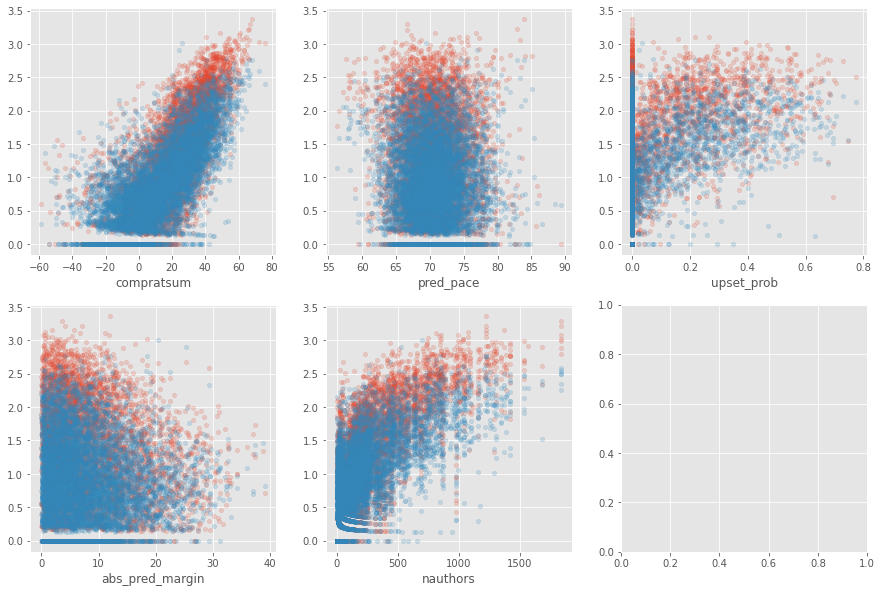

In [73]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
axs = axs.flatten()
ip = merged.is_postgame
for i,var in enumerate(['compratsum','pred_pace','upset_prob','abs_pred_margin','nauthors']):
    axs[i].scatter(merged[~ip][var], np.log10(merged[~ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].scatter(merged[ ip][var], np.log10(merged[ ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].set_xlabel(var)
    print(np.corrcoef(merged[ip][var], np.log10(merged[ip].norm_num_comments+1))[0,1])

In [74]:
merged.groupby('gid').mean().reset_index()

,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,preseason_effdiff,compratsum,prob,pred_margin,pred_total_blend,pred_pace,rank1,rank2,upset_prob,abs_pred_margin,is_rivalry
0,2017-11-11_duke_utah-valley,0.5,61.0,101.0,514.0,37.256132,23.244,21.943241,0.940544,17.466185,149.679055,72.503040,1.0,-1.0,0.059456,17.466185,0.0
1,2017-11-12_alabama-state_iowa,1.0,15.0,12.0,317.0,4.797967,-35.494,-2.447788,0.019506,-25.060452,148.983324,72.638984,-1.0,-1.0,0.000000,25.060452,0.0
2,2017-11-12_alcorn-state_creighton,0.5,8.5,5.0,105.0,2.473791,-30.533,4.328909,0.028563,-22.176727,147.298527,71.748981,-1.0,-1.0,0.000000,22.176727,0.0
3,2017-11-12_arizona_maryland-baltimore-county,0.5,35.5,55.0,304.0,22.151752,34.377,23.291402,0.976922,23.427986,148.943340,69.645355,3.0,-1.0,0.023078,23.427986,0.0
4,2017-11-12_arkansas_bucknell,0.0,15.0,9.0,142.0,4.181596,2.668,29.217430,0.711206,6.009927,150.408571,72.225536,-1.0,-1.0,0.000000,6.009927,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,2020-03-11_kansas-state_texas-christian,0.0,8.0,80.0,238.0,33.661860,0.383,20.226710,0.472766,-1.641030,131.679649,64.347224,-1.0,-1.0,0.000000,1.641030,0.0
8758,2020-03-11_minnesota_northwestern,0.0,13.0,162.0,311.0,64.988196,1.343,24.025947,0.799261,8.480522,137.310859,66.640257,-1.0,-1.0,0.000000,8.480522,0.0
8759,2020-03-11_north-carolina-state_pittsburgh,0.0,22.0,308.0,530.0,113.057566,13.318,19.731996,0.612651,3.687709,138.705712,67.470509,-1.0,-1.0,0.000000,3.687709,0.0
8760,2020-03-11_north-carolina_syracuse,0.0,43.0,1062.0,1054.0,351.325173,10.574,22.405270,0.541996,-0.399498,147.190042,71.449405,-1.0,-1.0,0.000000,0.399498,0.0


[0.57954788 0.12534788 0.02608884 0.04920225] 1.2003051549395876
0.644670730898943
0.48536885117494827


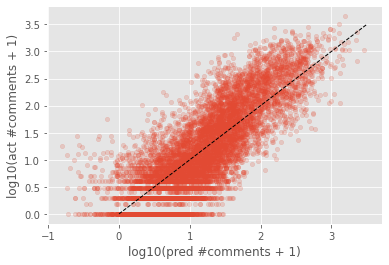

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

linreg = LinearRegression()
scaler = StandardScaler()

def is_before_march(gid):
    year, month, day = [int(x) for x in gid.split('_')[0].split('-')]
    if month > 9 or month < 3 or day < 10:
        return True
    return False

consol = merged[merged.gid.apply(is_before_march)].groupby('gid').mean().reset_index()
X = np.array([consol.compratsum, consol.upset_prob, consol.abs_pred_margin, consol.is_rivalry]).T
X = scaler.fit_transform(X)
y = np.log10(consol.num_comments + 1)
linreg.fit(X,y)
pred = linreg.predict(X)
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X,y))
print(mean_squared_error(y,pred)**0.5)

consol["score"] = 10**(pred)-1

plt.figure()
plt.scatter(pred, y, s=20, alpha=0.2)
plt.xlabel("log10(pred #comments + 1)")
plt.ylabel("log10(act #comments + 1)")
plt.plot([0,3.5],[0,3.5],'k--', lw=1)
# print(p)

/home/bennett/data_science/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gid,preseason_effdiff,num_comments,norm_num_comments,is_rivalry,compratsum,abs_pred_margin,upset_prob,score
5941,2019-11-12_creighton_michigan,-12.790,291.0,95.982196,0.0,35.855999,10.347375,0.000000,562.819274
5890,2019-11-09_purdue_texas,8.437,357.0,125.424356,0.0,44.664475,6.985433,0.000000,264.935761
5905,2019-11-10_florida_florida-state,3.166,276.0,104.724607,1.0,41.747591,6.189106,0.247015,218.959826
5895,2019-11-10_arizona_illinois,0.966,349.5,124.277948,0.0,35.402907,5.411184,0.000000,154.734780
5870,2019-11-08_kansas_north-carolina-greensboro,20.808,123.0,43.375678,0.0,27.067854,13.651281,0.102199,137.141608
5897,2019-11-10_binghamton_michigan-state,-47.098,180.5,61.415034,0.0,17.520870,30.834554,0.005177,126.801386
5943,2019-11-12_evansville_kentucky,-22.736,2101.0,737.981373,0.0,26.059357,20.302693,0.035034,120.750614
5883,2019-11-09_maryland_rhode-island,15.689,207.0,78.248377,0.0,31.839036,12.147976,0.116421,82.029185
5864,2019-11-08_colorado-state_duke,-27.675,37.0,13.602145,0.0,26.258844,18.430433,0.049957,72.988049
5868,2019-11-08_eastern-kentucky_kentucky,-32.167,70.5,24.817536,0.0,12.947863,21.700814,0.032674,66.951980


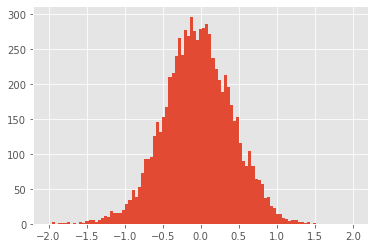

In [80]:
d1 = dt.date(2019,11,6)
d2 = dt.date(2019,11,13)
def between_dates(gid):
    date = dt.date(*[int(x) for x in gid.split('_')[0].split('-')])
    if d1 <= date and date < d2:
        return True
    return False

plt.figure()
plt.hist(np.log10(consol.score/consol.num_comments), bins=np.linspace(-2,2,100))

consol[['gid','preseason_effdiff','num_comments','norm_num_comments','is_rivalry','compratsum','abs_pred_margin','upset_prob','score']] \
    .sort_values('score', ascending=False) \
    .loc[consol.gid.apply(between_dates)].head(15)

In [81]:
with open('../models/reddit_regression.pkl', 'wb') as fid:
    pickle.dump(linreg, fid)

In [89]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor

X = np.array([consol.compratsum, consol.upset_prob, consol.abs_pred_margin, consol.is_rivalry]).T
y = np.log10(consol.num_comments + 1)

parameters = {'objective':['reg:squarederror'],
              'eval_metric': ['rmse'],
              'learning_rate': [0.015,0.02,0.025], #so called `eta` value
              'max_depth': [2,3],
              'min_child_weight': [20,25],
              'subsample': [0.3,0.4],
              'colsample_bytree': [1],
              'gamma': [0],
              'n_estimators': [300,400,500]}
xgb = XGBRegressor()
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        n_jobs = 4,
                        scoring='neg_mean_squared_error',
                        verbose=True)
xgb_grid.fit(X,
             y)

print(np.mean(-cross_val_score(xgb_grid.best_estimator_, X, y, cv=3, scoring='neg_mean_squared_error'))**0.5)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:  1.3min finished


[-0.22515057 -0.19848349 -0.21246331]
{'colsample_bytree': 1, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 2, 'min_child_weight': 20, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.3}
